In [4]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [5]:
import numpy as np

import qiskit.pulse as pulse
from qiskit.circuit import Parameter

from qiskit_experiments.calibration_management.backend_calibrations import BackendCalibrations

from qiskit import IBMQ, schedule

In [6]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

ibmqfactory.load_account:WARNING:2021-09-18 06:24:17,055: Credentials are already in use. The existing account in the session will be replaced.


In [7]:
qubit = 0  # The qubit we will work with

In [8]:
def setup_cals(backend) -> BackendCalibrations:
    """A function to instantiate calibrations and add a couple of template schedules."""
    cals = BackendCalibrations(backend)

    dur = Parameter("dur")
    amp = Parameter("amp")
    sigma = Parameter("σ")
    beta = Parameter("β")
    drive = pulse.DriveChannel(Parameter("ch0"))

    # Define and add template schedules.
    with pulse.build(name="xp") as xp:
        pulse.play(pulse.Drag(dur, amp, sigma, beta), drive)

    with pulse.build(name="xm") as xm:
        pulse.play(pulse.Drag(dur, -amp, sigma, beta), drive)

    with pulse.build(name="x90p") as x90p:
        pulse.play(pulse.Drag(dur, Parameter("amp"), sigma, Parameter("β")), drive)

    cals.add_schedule(xp)
    cals.add_schedule(xm)
    cals.add_schedule(x90p)

    return cals

def add_parameter_guesses(cals: BackendCalibrations):
    """Add guesses for the parameter values to the calibrations."""
    for sched in ["xp", "x90p"]:
        cals.add_parameter_value(80, "σ", schedule=sched)
        cals.add_parameter_value(0.5, "β", schedule=sched)
        cals.add_parameter_value(320, "dur", schedule=sched)
        cals.add_parameter_value(0.5, "amp", schedule=sched)

In [9]:
cals = setup_cals(backend)
add_parameter_guesses(cals)

In [10]:
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

In [11]:
library = FixedFrequencyTransmon(default_values={"duration": 320})
cals = BackendCalibrations(backend, library)

# 1. Finding qubits with spectroscopy
Here, we are using a backend for which we already know the qubit frequency. We will therefore use the spectroscopy experiment to confirm that there is a resonance at the qubit frequency reported by the backend.



In [12]:
from qiskit_experiments.library.characterization.qubit_spectroscopy import QubitSpectroscopy

In [13]:
import pandas as pd

pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()]))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.000000e+00,2021-09-18 06:24:35.360875+0000,True,None,default,(),β,x
1,6.993371e+09,2021-09-18 06:24:35.360586+0000,True,None,default,"(0,)",meas_lo_freq,None
2,4.971598e+09,2021-09-18 06:24:35.360561+0000,True,None,default,"(0,)",qubit_lo_freq,None
3,8.000000e+01,2021-09-18 06:24:35.360971+0000,True,None,default,(),σ,sx
4,8.000000e+01,2021-09-18 06:24:35.360853+0000,True,None,default,(),σ,x
5,2.500000e-01,2021-09-18 06:24:35.360959+0000,True,None,default,(),amp,sx
6,5.000000e-01,2021-09-18 06:24:35.360837+0000,True,None,default,(),amp,x
7,3.200000e+02,2021-09-18 06:24:35.360992+0000,True,None,default,(),duration,sx
8,0.000000e+00,2021-09-18 06:24:35.360982+0000,True,None,default,(),β,sx
9,3.200000e+02,2021-09-18 06:24:35.360865+0000,True,None,default,(),duration,x


In [14]:
freq01_estimate = backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate -15e6, freq01_estimate + 15e6, 51)
spec = QubitSpectroscopy(qubit, frequencies)
spec.set_experiment_options(amp=0.1)

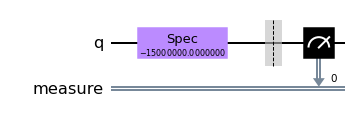

In [15]:
circuit = spec.circuits(backend)[0]
circuit.draw(output="mpl")

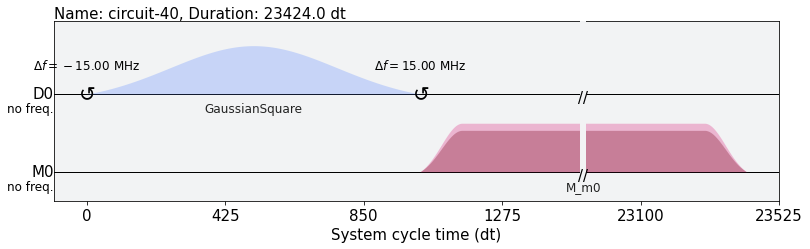

In [16]:
schedule(circuit, backend).draw()

In [17]:
spec_data = spec.run(backend)

In [18]:
spec_data.block_for_results()

ExperimentData(QubitSpectroscopy, f41aa08e-6973-4579-826e-53e68310ffb6, backend=ibmq_armonk, job_ids=['614586356feb7e62236f83fa'])

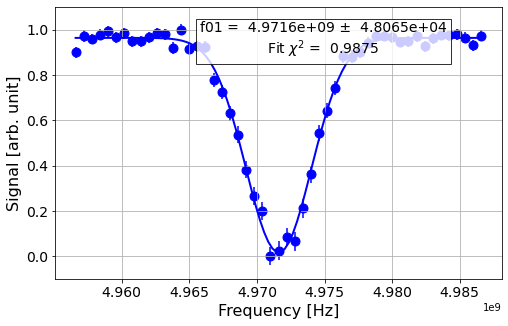

In [20]:
spec_data.figure(0)

In [21]:
print(spec_data.analysis_results("f01"))

DbAnalysisResultV1
- name: f01
- value: 4971613659.252058 ± 48065.19047869252 Hz
- χ²: 0.9874882254554365
- quality: good
- device_components: ['Q0']
- verified: False


In [22]:
from qiskit_experiments.calibration_management.update_library import Frequency

Frequency.update(cals, spec_data)

In [23]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit]))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,6.993371e+09,2021-09-18 06:24:35.360586+0000,True,None,default,"(0,)",meas_lo_freq,None
1,4.971598e+09,2021-09-18 06:24:35.360561+0000,True,None,default,"(0,)",qubit_lo_freq,None
2,4.971614e+09,2021-09-18 06:36:59.031000+0000,True,f41aa08e-6973-4579-826e-53e68310ffb6,default,"(0,)",qubit_lo_freq,None


# 2. Calibrating the pulse amplitudes with a Rabi experiment¶
In the Rabi experiment we apply a pulse at the frequency of the qubit and scan its amplitude to find the amplitude that creates a rotation of a desired angle.

In [25]:
from qiskit_experiments.library.calibration import Rabi
from qiskit_experiments.calibration_management.update_library import Amplitude

In [26]:
rabi = Rabi(qubit)
rabi.set_experiment_options(
    amplitudes=np.linspace(-0.95, 0.95, 51),
    schedule=cals.get_schedule("x", (qubit,), assign_params={"amp": Parameter("amp")}),
)

In [27]:
rabi_data = rabi.run(backend)
rabi_data.block_for_results()

ExperimentData(Rabi, e59fd27b-b74f-4893-9356-0b76bca3f154, backend=ibmq_armonk, job_ids=['614563826d2d528685537e44'])

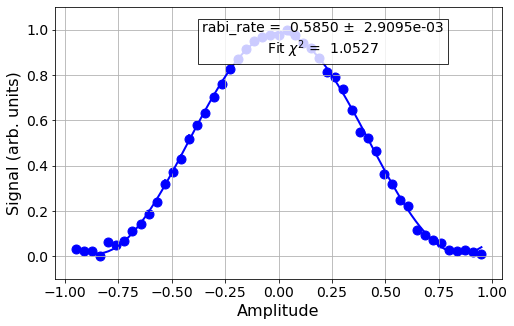

In [28]:
rabi_data.figure(0)

In [29]:
print(rabi_data.analysis_results("rabi_rate"))

DbAnalysisResultV1
- name: rabi_rate
- value: 0.5850119775355096 ± 0.0029095234656490135
- χ²: 1.0526745063694707
- quality: good
- device_components: ['Q0']
- verified: False


In [30]:
Amplitude.update(cals, rabi_data, angles_schedules=[(np.pi, "amp", "x"), (np.pi/2, "amp", "sx")])

In [31]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.427342+0.000000j,2021-09-18 04:07:42.149000+0000,True,e59fd27b-b74f-4893-9356-0b76bca3f154,default,"(0,)",amp,sx
1,0.500000+0.000000j,2021-09-18 02:29:11.534313+0000,True,None,default,(),amp,x
2,0.854683+0.000000j,2021-09-18 04:07:42.149000+0000,True,e59fd27b-b74f-4893-9356-0b76bca3f154,default,"(0,)",amp,x
3,0.250000+0.000000j,2021-09-18 02:29:11.534386+0000,True,None,default,(),amp,sx


In [32]:
cals.get_schedule("sx", qubit)

ScheduleBlock(Play(Drag(duration=320, amp=(0.42734168+0j), sigma=80, beta=0), DriveChannel(0)), name="sx", transform=AlignLeft())

In [33]:
cals.get_schedule("x", qubit)

ScheduleBlock(Play(Drag(duration=320, amp=(0.85468336+0j), sigma=80, beta=0), DriveChannel(0)), name="x", transform=AlignLeft())

In [34]:
cals.get_schedule("y", qubit)

ScheduleBlock(Play(Drag(duration=320, amp=0.85468336j, sigma=80, beta=0), DriveChannel(0)), name="y", transform=AlignLeft())

# 3. Saving and loading calibrations¶
The values of the calibrated parameters can be saved to a .csv file and reloaded at a later point in time.

In [35]:
cals = BackendCalibrations(backend, library)
cals.load_parameter_values(file_name="Armonkparameter_values.csv")

Traceback (most recent call last):
  File "<ipython-input-35-f339eb19e7ad>", line 2, in <module>
    cals.load_parameter_values(file_name="Armonkparameter_values.csv")
  File "/opt/conda/lib/python3.8/site-packages/qiskit_experiments/calibration_management/calibrations.py", line 1015, in load_parameter_values
    with open(file_name, encoding="utf-8") as fp:
FileNotFoundError: [Errno 2] No such file or directory: 'Armonkparameter_values.csv'

Use %tb to get the full traceback.


In [36]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.50,2021-09-18 04:30:36.985511+0000,True,None,default,(),amp,x
1,0.25,2021-09-18 04:30:36.985583+0000,True,None,default,(),amp,sx


# 4. Calibrating the value of the DRAG coefficient¶
A Derivative Removal by Adiabatic Gate (DRAG) pulse is designed to minimize leakage to a neighbouring transition. It is a standard pulse with an additional derivative component. It is designed to reduce the frequency spectrum of a normal pulse near the  -  transition, reducing the chance of leakage to the  state. The optimal value of the DRAG parameter is chosen to minimize both leakage and phase errors resulting from the AC Stark shift. The pulse envelope is 
 
. Here,  is the envelop of the in-phase component of the pulse and  is the strength of the quadrature which we refer to as the DRAG parameter and seek to calibrate in this experiment. The DRAG calibration will run several series of circuits. In a given circuit a Rp(β) - Rm(β) block is repeated  times. Here, Rp is a rotation with a positive angle and Rm is the same rotation with a negative amplitude.

In [2]:
from qiskit_experiments.library.calibration.drag import DragCal
from qiskit_experiments.calibration_management.update_library import Drag

In [24]:
cal_drag = DragCal(qubit)

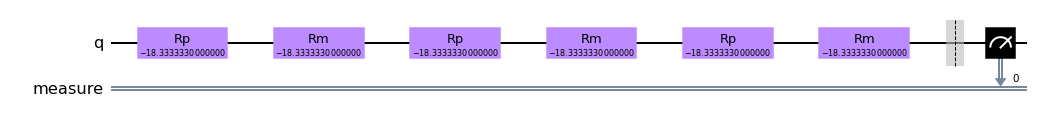

In [25]:
cal_drag.set_experiment_options(
    rp=cals.get_schedule("x", qubit, assign_params={"β": Parameter("β")}),
    betas=np.linspace(-20, 20, 25),
    reps=[3, 5, 7]
)

cal_drag.circuits(backend)[1].draw(output='mpl')

In [26]:
drag_data = cal_drag.run(backend)
drag_data.block_for_results()

ExperimentData(DragCal, 67da2546-9205-423d-8262-e994b7f06405, backend=ibmq_armonk, job_ids=['61458bec6d2d52c4fe537fe5'])

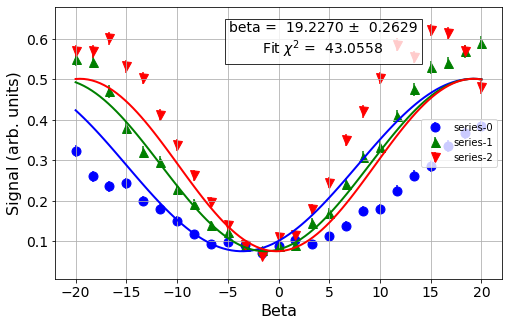

In [27]:
drag_data.figure(0)

In [28]:
print(drag_data.analysis_results("beta"))

DbAnalysisResultV1
- name: beta
- value: 19.226981764988434 ± 0.26286256080697706
- χ²: 43.05575301473419
- quality: bad
- device_components: ['Q0']
- verified: False


In [29]:
Drag.update(cals, drag_data, parameter="β", schedule="x")

In [30]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="β"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.000000,2021-09-18 06:24:35.360982+0000,True,None,default,(),β,sx
1,0.000000,2021-09-18 06:24:35.360875+0000,True,None,default,(),β,x
2,19.226982,2021-09-18 06:57:47.113000+0000,True,67da2546-9205-423d-8262-e994b7f06405,default,"(0,)",β,x


# 5. Fine amplitude calibration¶
The FineAmplitude calibration experiment repeats  times a gate with a pulse to amplify the under or over-rotations in the gate to determine the optimal amplitude. The circuits that are run have a custom gate with the pulse schedule attached to it through the calibrations.

In [31]:
from qiskit_experiments.library.calibration.fine_amplitude import FineXAmplitude
from qiskit_experiments.calibration_management.update_library import Amplitude

In [32]:
amp_x_cal = FineXAmplitude(qubit)
amp_x_cal.set_experiment_options(schedule=cals.get_schedule("x", qubit))

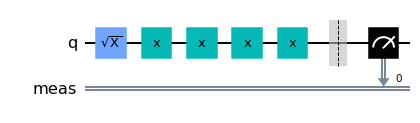

In [33]:
amp_x_cal.circuits(backend)[5].draw(output="mpl")

In [34]:
data_fine = amp_x_cal.run(backend)
data_fine.block_for_results()

ExperimentData(FineXAmplitude, 75dc4c17-4800-455f-8d41-0a68f6625e12, backend=ibmq_armonk, job_ids=['61459389010c168cd256724b'])

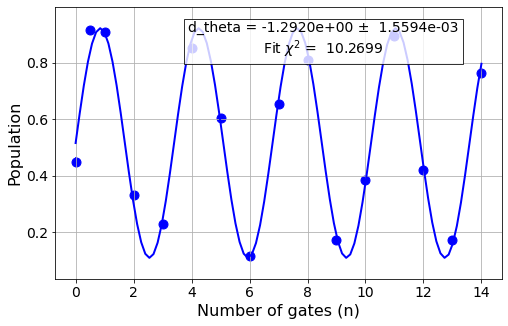

In [36]:
data_fine.figure(0)

In [37]:
print(data_fine.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: -1.2919979481313841 ± 0.0015593870466044388
- χ²: 10.269915284906803
- quality: bad
- device_components: ['Q0']
- verified: False


In [38]:
dtheta = data_fine.analysis_results("d_theta").value.value
target_angle = np.pi
scale = target_angle / (target_angle + dtheta)
pulse_amp = cals.get_parameter_value("amp", qubit, "x")
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")

The ideal angle is 3.14 rad. We measured a deviation of -1.292 rad.
Thus, scale the 0.5000 pulse amplitude by 1.699 to obtain 0.84927.


In [39]:
Amplitude.update(cals, data_fine, angles_schedules=[(target_angle, "amp", "x")])

In [40]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.250000,2021-09-18 06:24:35.360959+0000,True,None,default,(),amp,sx
1,0.500000,2021-09-18 06:24:35.360837+0000,True,None,default,(),amp,x
2,0.849265,2021-09-18 07:24:00.309000+0000,True,75dc4c17-4800-455f-8d41-0a68f6625e12,default,"(0,)",amp,x


In [41]:
amp_x_cal.set_experiment_options(schedule=cals.get_schedule("x", qubit))

In [42]:
data_fine2 = amp_x_cal.run(backend)
data_fine2.block_for_results()

ExperimentData(FineXAmplitude, 124911ac-6c29-4832-b581-65ddb87047c6, backend=ibmq_armonk, job_ids=['6145959d010c16321e56726f'])

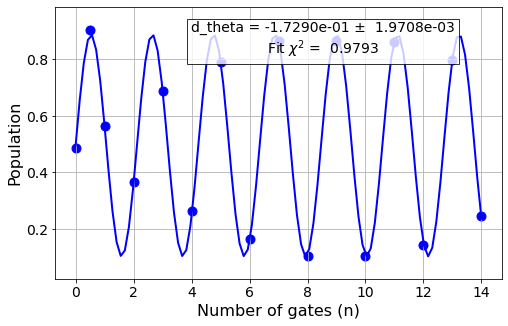

In [43]:
data_fine2.figure(0)

In [44]:
print(data_fine2.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: -0.17289590547506825 ± 0.0019708209569658064
- χ²: 0.9793427198410758
- quality: good
- device_components: ['Q0']
- verified: False
